In [ ]:
import os
import cv2
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 폴더 경로 설정 (Google 드라이브 경로에 따라 조정)
data_folder = '/content/drive/MyDrive/헴프데이터 1000개'

image_data = []
labels = []

# 각 서브폴더 순회
for class_folder in os.listdir(data_folder):
    class_path = os.path.join(data_folder, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder  # 서브폴더 이름을 클래스 라벨로 사용
        for image_file in os.listdir(class_path):
            if image_file.endswith(".jpg"):
                image_path = os.path.join(class_path, image_file)

                # 이미지 읽기
                image = cv2.imread(image_path)
                # 이미지 크기 조정 (필요에 따라 조정)
                image = cv2.resize(image, (150, 150))
                image_data.append(image)

                # 라벨링 데이터 추가
                labels.append(class_label)

# 이미지 데이터와 라벨링 데이터를 NumPy 배열로 변환
image_data = np.array(image_data)
labels = np.array(labels)

# 클래스 라벨을 숫자로 변환
unique_labels = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
labels = [label_to_index[label] for label in labels]

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

# 데이터 분할 (훈련 및 검증 데이터)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# 이미지 데이터 정규화 (0~1 범위)
X_train = X_train / 255.0
X_val = X_val / 255.0

# CNN 모델 정의
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(unique_labels), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # 다중 클래스 분류
              metrics=['accuracy'])
X_train = np.array(X_train)
X_val = np.array(X_val)

# 라벨 데이터를 NumPy 배열로 변환
y_train = np.array(y_train)
y_val = np.array(y_val)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 체크포인트를 저장할 경로 지정
checkpoint_path = 'model_checkpoint.h5'

# ModelCheckpoint 콜백 설정
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# EarlyStopping 콜백 설정
early_stopping_callback = EarlyStopping(patience=5, monitor='val_loss', mode='min', verbose=1)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.7887
Epoch 1: val_loss improved from inf to 0.28479, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 16s 48ms/step - loss: 0.7412 - accuracy: 0.7887 - val_loss: 0.2848 - val_accuracy: 0.8683
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9287
Epoch 2: val_loss improved from 0.28479 to 0.20609, saving model to model_checkpoint.h5
75/75 [==============================] - 4s 56ms/step - loss: 0.1837 - accuracy: 0.9287 - val_loss: 0.2061 - val_accuracy: 0.9300
Epoch 3/10
73/75 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9842
Epoch 3: val_loss did not improve from 0.20609
75/75 [==============================] - 2s 27ms/step - loss: 0.0635 - accuracy: 0.9825 - val_loss: 0.2584 - val_accuracy: 0.9317
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9900
Epoch 4: val_loss did not improve from 0.20609
75/75 [==============================] - 2s 24ms/step - loss: 0.0332 - accuracy: 0.9900 - val_loss: 0.2226 - val_accuracy: 0.9283
Epoch 5/10
73/7

1/1 [==============================] - 0s 32ms/step


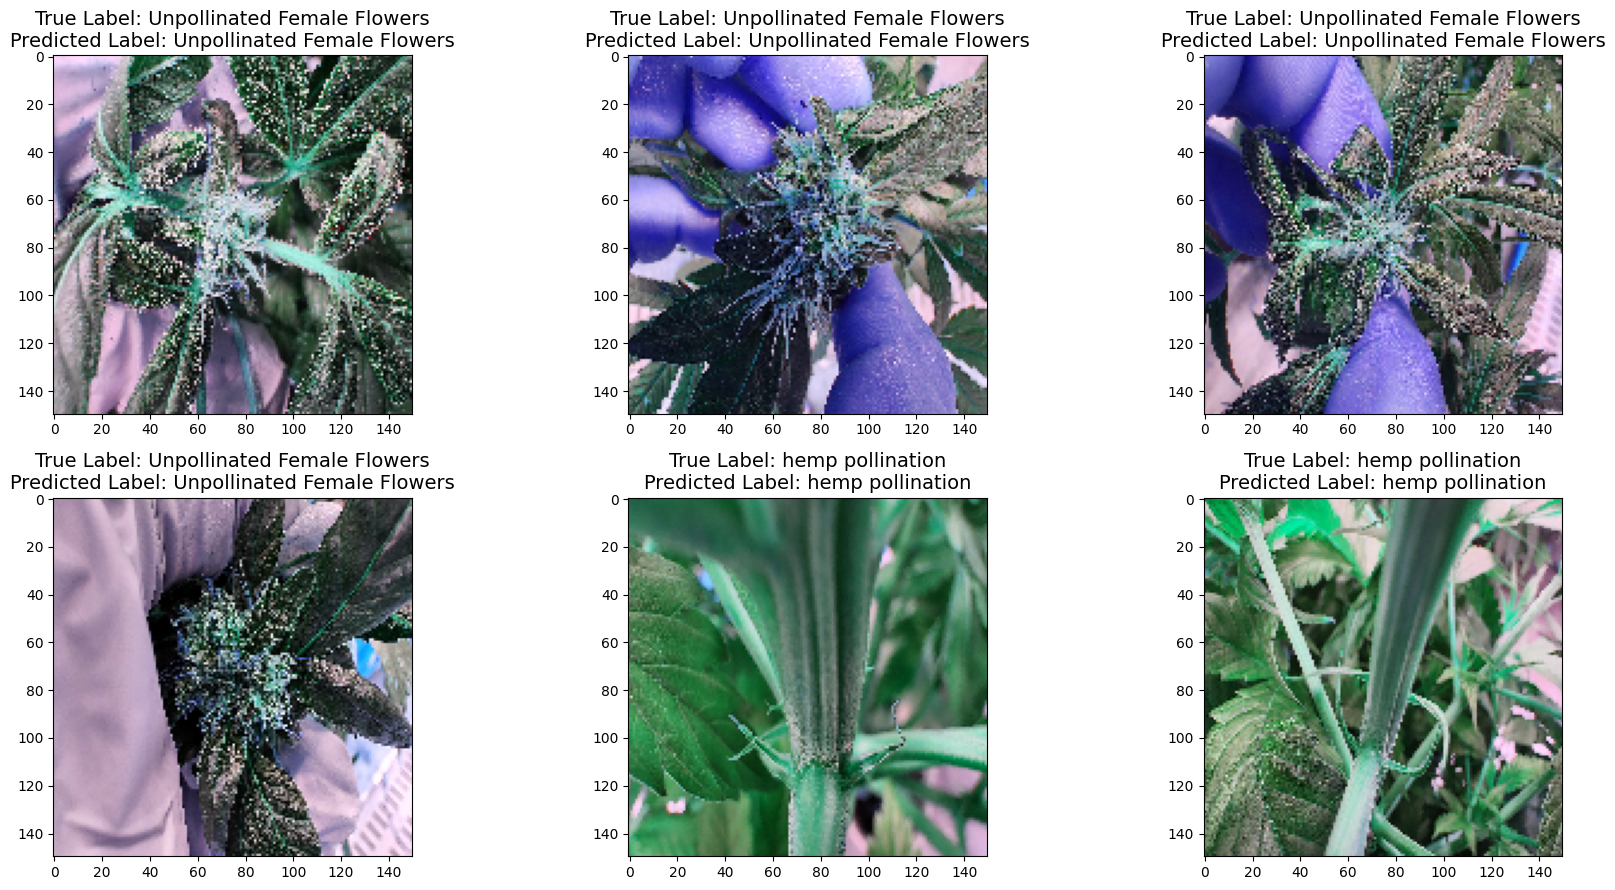

In [ ]:
import matplotlib.pyplot as plt
import random

# 6개의 임의의 인덱스 선택
indices = random.sample(range(len(X_val)), 6)

# 6개의 이미지 및 예측 결과 표시
plt.figure(figsize=(18, 9))  # 그림 크기 설정

for i, index in enumerate(indices):
    sample_image = X_val[index]
    sample_label = y_val[index]

    # 모델에 이미지를 입력하여 예측
    predicted_label = model.predict(np.expand_dims(sample_image, axis=0))
    predicted_label = np.argmax(predicted_label)

    # 클래스 라벨을 실제 클래스 이름으로 변환 (optional)
    class_names = {0: 'Unpollinated Female Flowers', 1: 'fe/male Flowers', 2: 'hemp pollination'}

    plt.subplot(2, 3, i + 1)  # 2x3 그리드에서 i번째 위치
    plt.imshow(sample_image)
    plt.title(f"True Label: {class_names[sample_label]}\nPredicted Label: {class_names[predicted_label]}", fontsize=14)

plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()

1/1 [==============================] - 0s 18ms/step


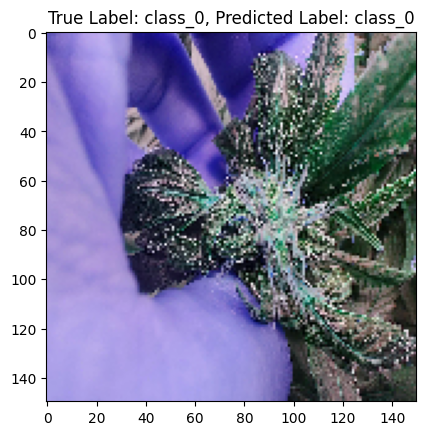

In [ ]:
import matplotlib.pyplot as plt
import random

# 검증 데이터에서 임의의 이미지를 선택
index = random.randint(0, len(X_val) - 1)
sample_image = X_val[index]
sample_label = y_val[index]

# 모델에 이미지를 입력하여 예측
predicted_label = model.predict(np.expand_dims(sample_image, axis=0))
predicted_label = np.argmax(predicted_label)

# 클래스 라벨을 실제 클래스 이름으로 변환 (optional)
class_names = {0: 'Vegetative Growth Stage', 1: 'Flowering Stage', 2: 'Unpollinated Female Flowers'}  # 클래스 라벨과 실제 클래스 이름의 매핑

# 이미지 및 예측 결과 시각화
plt.imshow(sample_image)
plt.title(f"True Label: {class_names[sample_label]}, Predicted Label: {class_names[predicted_label]}")
plt.show()

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# 모델에 검증 데이터를 입력하고 예측 결과를 얻은 다음 평가합니다.
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
report = classification_report(y_val, y_pred_classes, target_names=unique_labels)
print(report)

19/19 [==============================] - 0s 10ms/step - loss: 0.3377 - accuracy: 0.9450
Validation Loss: 0.3377
Validation Accuracy: 0.9450
19/19 [==============================] - 0s 8ms/step
               precision    recall  f1-score   support

미수정암꽃       0.96      0.95      0.95       186
  암꽃수꽃       0.94      0.92      0.93       217
    화아분화       0.94      0.97      0.96       197

     accuracy                           0.94       600
    macro avg       0.95      0.95      0.95       600
 weighted avg       0.95      0.94      0.94       600



Epoch 1/10
73/75 [============================>.] - ETA: 0s - loss: 6.7181e-06 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.31013, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 3s 36ms/step - loss: 6.7556e-06 - accuracy: 1.0000 - val_loss: 0.3101 - val_accuracy: 0.9467
Epoch 2/10
73/75 [============================>.] - ETA: 0s - loss: 6.0568e-06 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.31013
75/75 [==============================] - 2s 24ms/step - loss: 6.0263e-06 - accuracy: 1.0000 - val_loss: 0.3215 - val_accuracy: 0.9467
Epoch 3/10
73/75 [============================>.] - ETA: 0s - loss: 5.3543e-06 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.31013
75/75 [==============================] - 2s 24ms/step - loss: 5.4142e-06 - accuracy: 1.0000 - val_loss: 0.3191 - val_accuracy: 0.9450
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 4.8073e-06 - accuracy: 1.0000
Epoch 4: val_loss did not improve from 0.31013
75/75 [==============================] - 2s 27ms/step - loss: 4.8073e-06 - accuracy: 1.0000 - val_loss: 0.3291 - val_accuracy: 0.9450
Epoch 5/10
73/75 [===========

19/19 [==============================] - 0s 18ms/step
Validation Accuracy: 0.9550


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 4353 (\N{HANGUL CHOSEONG SSANGKIYEOK}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 4457 (\N{HANGUL JUNGSEONG O}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 4542 (\N{HANGUL JONGSEONG CHIEUCH}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 4358 (\N{HANGUL CHOSEONG MIEUM}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 4469 (\N{HANGUL JUNGSEONG I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 4361 (\N{HANGUL CHOSEONG SIOS}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-package

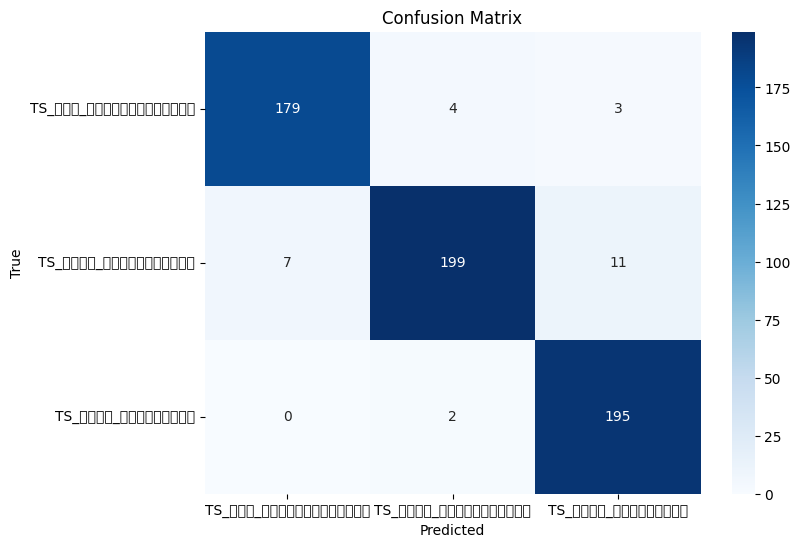

                      precision    recall  f1-score   support

TS_꽃_미수정암꽃       0.96      0.96      0.96       186
 TS_마디_암꽃수꽃       0.97      0.92      0.94       217
   TS_마디_화아분화       0.93      0.99      0.96       197

            accuracy                           0.95       600
           macro avg       0.96      0.96      0.96       600
        weighted avg       0.96      0.95      0.95       600



In [ ]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# 정확도 계산
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_pred_classes)
print(f"Validation Accuracy: {accuracy:.4f}")

# 혼동 행렬 생성
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 다른 평가 메트릭 계산 (정밀도, 재현율, F1 스코어 등)
from sklearn.metrics import classification_report
report = classification_report(y_val, y_pred_classes, target_names=unique_labels)
print(report)

In [ ]:
# 평가 지표 계산
from sklearn.metrics import precision_score, recall_score, f1_score

# 예측값 변환
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# 평가 지표 계산
precision = precision_score(y_val, y_val_pred_classes, average='weighted')
recall = recall_score(y_val, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val, y_val_pred_classes, average='weighted')

# 평가 지표를 표 형태로 출력
evaluation_table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Score': [precision, recall, f1]
})

print("Evaluation Metrics:")
print(evaluation_table)

19/19 [==============================] - 0s 8ms/step
Evaluation Metrics:
      Metric     Score
0  Precision  0.945143
1     Recall  0.945000
2   F1 Score  0.944882


Epoch 1/10
75/75 [==============================] - 2s 30ms/step - loss: 6.0597e-05 - accuracy: 1.0000 - val_loss: 0.2201 - val_accuracy: 0.9483
Epoch 2/10
75/75 [==============================] - 2s 22ms/step - loss: 5.1222e-05 - accuracy: 1.0000 - val_loss: 0.2316 - val_accuracy: 0.9500
Epoch 3/10
75/75 [==============================] - 2s 26ms/step - loss: 4.2406e-05 - accuracy: 1.0000 - val_loss: 0.2288 - val_accuracy: 0.9483
Epoch 4/10
75/75 [==============================] - 2s 27ms/step - loss: 3.7271e-05 - accuracy: 1.0000 - val_loss: 0.2389 - val_accuracy: 0.9467
Epoch 5/10
75/75 [==============================] - 2s 26ms/step - loss: 3.1560e-05 - accuracy: 1.0000 - val_loss: 0.2473 - val_accuracy: 0.9467
Epoch 6/10
75/75 [==============================] - 2s 23ms/step - loss: 2.7442e-05 - accuracy: 1.0000 - val_loss: 0.2498 - val_accuracy: 0.9467
Epoch 7/10
75/75 [==============================] - 2s 32ms/step - loss: 2.3552e-05 - accuracy: 1.0000 - val_loss: 0.2562 - val_ac

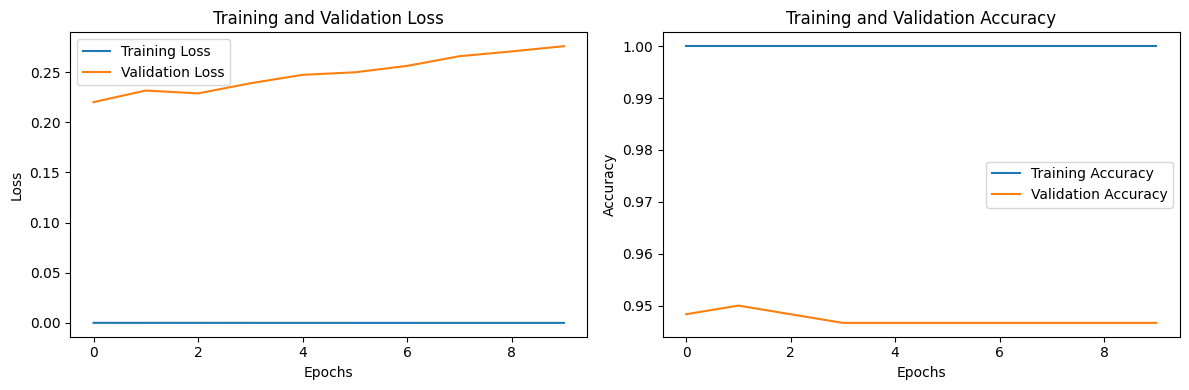

In [ ]:
from sklearn.metrics import average_precision_score

# 검증 데이터에 대한 예측
y_val_pred = model.predict(X_val)

# 각 클래스에 대한 Average Precision 계산
average_precisions = []
for i in range(len(unique_labels)):
    average_precisions.append(average_precision_score(y_val == i, y_val_pred[:, i]))

# Mean Average Precision 계산
mean_average_precision = np.mean(average_precisions)

# 각 클래스별 Average Precision 값을 출력
print("Average Precision for each class:")
for i, label in enumerate(unique_labels):
    print(f"Class '{label}': {average_precisions[i]:.4f}")

# Mean Average Precision 출력
print(f"\nMean Average Precision (mAP): {mean_average_precision:.4f}")

19/19 [==============================] - 0s 10ms/step
Average Precision for each class:
Class '미수정암꽃': 0.9945
Class '암꽃수꽃': 0.9850
Class '화아분화': 0.9944

Mean Average Precision (mAP): 0.9913


In [ ]:
# 데이터 폴더 경로 설정 (Google 드라이브 경로에 따라 조정)
data_folder = '/content/drive/MyDrive/헴프데이터 1000개'

image_data = []
labels = []

# 각 서브폴더 순회
for class_folder in os.listdir(data_folder):
    class_path = os.path.join(data_folder, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder  # 서브폴더 이름을 클래스 라벨로 사용
        for image_file in os.listdir(class_path):
            if image_file.endswith(".jpg"):
                image_path = os.path.join(class_path, image_file)

                # 이미지 읽기
                image = cv2.imread(image_path)
                # 이미지 크기 조정 (필요에 따라 조정)
                image = cv2.resize(image, (150, 150))
                image_data.append(image)

                # 라벨링 데이터 추가
                labels.append(class_label)

plt.figure(figsize=(10, 10))
for i in range(9):  # 처음 9개 이미지만 시각화
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(image_data[i], cv2.COLOR_BGR2RGB))
    plt.title(labels[i])
    plt.axis("off")

NameError: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4358 (\N{HANGUL CHOSEONG MIEUM}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4469 (\N{HANGUL JUNGSEONG I}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4361 (\N{HANGUL CHOSEONG SIOS}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4462 (\N{HANGUL JUNGSEONG U}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4364 (\N{HANGUL CHOSEONG CIEUC}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 4453 (\N{HANGUL JUNGSEONG EO}) missing from current font.
  func(*args,

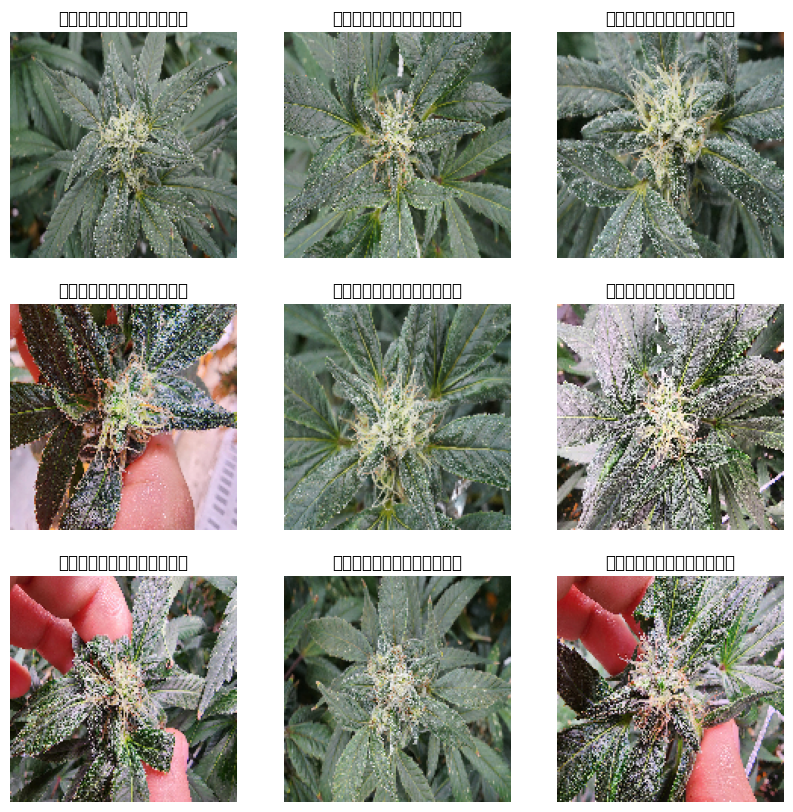

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):  # 처음 9개 이미지만 시각화
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(image_data[i], cv2.COLOR_BGR2RGB))
    plt.title(labels[i])
    plt.axis("off")